In [1]:
# Install Dependencies
!pip install -q transformers accelerate medmnist torchvision bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.7/60.7 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 12.4 MB/s eta 0:00:00


In [2]:
# Imports
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import transforms
from medmnist import PneumoniaMNIST
from transformers import LlavaProcessor, LlavaForConditionalGeneration


In [3]:
# Enable GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))


Using device: cuda
Tesla T4


In [4]:
transform = transforms.Compose([
    transforms.ToTensor()
])

dataset = PneumoniaMNIST(
    split="test",
    transform=transform,
    download=True
)

print("Test samples:", len(dataset))


100%|██████████| 4.17M/4.17M [00:01<00:00, 3.19MB/s]

Test samples: 624


In [6]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import transforms
from medmnist import PneumoniaMNIST
from transformers import LlavaProcessor, LlavaForConditionalGeneration

# Load Model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)

        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)

        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = self.relu3(self.fc1(x))
        return self.fc2(x)

cnn_model = SimpleCNN()
cnn_model.load_state_dict(torch.load("simple_cnn.pth", map_location=device))
cnn_model.to(device)
cnn_model.eval()

print("CNN Loaded.")

CNN Loaded.


In [7]:
MODEL_NAME = "llava-hf/llava-1.5-7b-hf"

print("Loading VLM...")
processor = LlavaProcessor.from_pretrained(MODEL_NAME)

model = LlavaForConditionalGeneration.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float16,
    device_map="auto",
    low_cpu_mem_usage=True
)

model.eval()
print("VLM Loaded.")


Loading VLM...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


processor_config.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/701 [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/674 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/505 [00:00<?, ?B/s]

The image processor of type `CLIPImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. 


config.json:   0%|          | 0.00/950 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/41.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/686 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

VLM Loaded.


In [8]:
PROMPTS = {
    "basic": "Describe this chest X-ray image.",

    "radiologist": """You are a medical radiologist.
Describe the key findings and give a possible diagnosis.""",

    "structured": """You are an expert thoracic radiologist.
Analyze the chest X-ray focusing on:
- Lung opacity
- Consolidation
- Infiltrates
Provide a concise clinical report."""
}


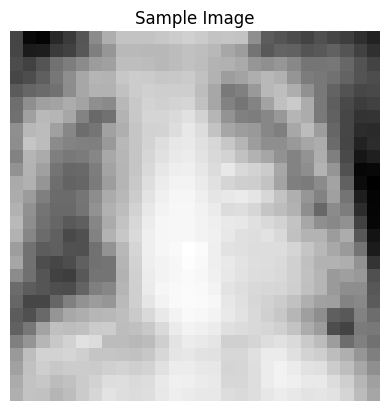

Ground Truth: 1

--- Prompt: basic ---
USER:  
Describe this chest X-ray image.ASSISTANT: The image is a black and white chest X-ray of a person. The focus is on the upper part of the chest, where the lungs are visible. The lungs are located in the upper part of the image, with the left lung occupying a larger portion of the space. The right lung is smaller and positioned more towards the center of the image. The overall appearance of the chest X-ray is clear and well-defined.

--- Prompt: radiologist ---
USER:  
You are a medical radiologist.
Describe the key findings and give a possible diagnosis.ASSISTANT: The image displays a close-up view of a person's chest, focusing on the lungs and the surrounding area. The lungs are visible, and there is a noticeable shadow in the middle of the chest. This shadow could be indicative of a foreign object, such as a piece of metal or a medical device, lodged in the chest.

Given the presence of the shadow and the close-up nature of the image, it 

In [10]:
def generate_report(image, prompt):
    # Format the prompt to include the <image> token as expected by Llava
    formatted_prompt = f"USER: <image>\n{prompt}ASSISTANT:"

    inputs = processor(
        text=formatted_prompt,
        images=image,
        return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        output = model.generate(
            **inputs,
            max_new_tokens=200
        )

    return processor.decode(output[0], skip_special_tokens=True)


# Test on one sample
img, label = dataset[0]
img_pil = transforms.ToPILImage()(img)

plt.imshow(img.squeeze(), cmap="gray")
plt.title("Sample Image")
plt.axis("off")
plt.show()

print("Ground Truth:", label.item())

for name, prompt in PROMPTS.items():
    print(f"\n--- Prompt: {name} ---")
    report = generate_report(img_pil, prompt)
    print(report)

In [11]:
misclassified = []

for i in range(len(dataset)):
    img, label = dataset[i]
    input_tensor = img.unsqueeze(0).to(device)

    with torch.no_grad():
        output = cnn_model(input_tensor)
        pred = torch.argmax(output, dim=1).item()

    if pred != label.item():
        misclassified.append(i)

    if len(misclassified) == 3:
        break

print("Misclassified indices:", misclassified)


Misclassified indices: [1, 3, 9]


Integrated CNN + VLM Evaluation


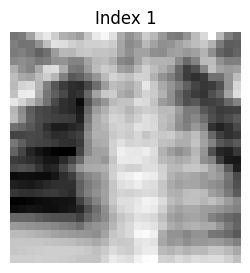

Ground Truth   : 0
CNN Prediction : 1
CNN Status     : ❌ Misclassified

VLM Report:

USER:  
You are an expert thoracic radiologist.
Analyze the chest X-ray focusing on:
- Lung opacity
- Consolidation
- Infiltrates
Provide a concise clinical report.ASSISTANT: The chest X-ray shows a large, irregularly shaped mass in the right upper lobe of the lung. The mass appears to be infiltrating the surrounding lung tissue, causing a significant amount of consolidation. The presence of this mass suggests the possibility of a malignant tumor, such as a lung cancer. The patient should be referred to a specialist for further evaluation and management.

----------------------------------------------------------------------



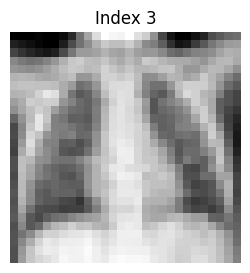

Ground Truth   : 0
CNN Prediction : 1
CNN Status     : ❌ Misclassified

VLM Report:

USER:  
You are an expert thoracic radiologist.
Analyze the chest X-ray focusing on:
- Lung opacity
- Consolidation
- Infiltrates
Provide a concise clinical report.ASSISTANT: The image displays a chest X-ray of a person, focusing on the lungs and the surrounding area. There is a noticeable opacity in the left lower lobe of the lung, which could indicate a consolidation or infiltrate. The presence of this opacity suggests that the patient might be experiencing respiratory issues or an infection in the affected area. It is essential to consult a medical professional for further evaluation and treatment.

----------------------------------------------------------------------



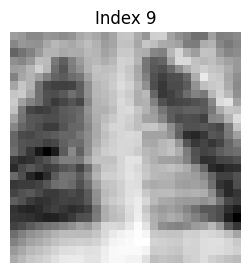

Ground Truth   : 0
CNN Prediction : 1
CNN Status     : ❌ Misclassified

VLM Report:

USER:  
You are an expert thoracic radiologist.
Analyze the chest X-ray focusing on:
- Lung opacity
- Consolidation
- Infiltrates
Provide a concise clinical report.ASSISTANT: The chest X-ray shows a right-sided lung infiltrate, which is a type of lung opacity. The infiltrate is located in the lower lobe of the right lung, and it appears to be a consolidation, which is a type of lung consolidation. The presence of this infiltrate suggests that the patient may have an underlying respiratory condition, such as chronic obstructive pulmonary disease (COPD) or lung cancer. It is important for the patient to seek medical attention to determine the cause of the infiltrate and to receive appropriate treatment.

----------------------------------------------------------------------



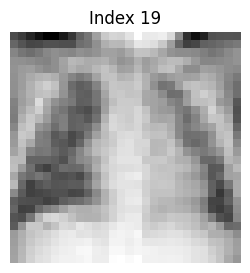

Ground Truth   : 0
CNN Prediction : 1
CNN Status     : ❌ Misclassified

VLM Report:

USER:  
You are an expert thoracic radiologist.
Analyze the chest X-ray focusing on:
- Lung opacity
- Consolidation
- Infiltrates
Provide a concise clinical report.ASSISTANT: The image displays a chest X-ray of a person, focusing on the lungs and surrounding areas. There is a noticeable opacity in the left lower lobe of the lung, which could indicate a consolidation or infiltrate. The presence of this opacity suggests that the patient might be experiencing respiratory issues or an infection. It is essential to consult a medical professional for further evaluation and treatment.

----------------------------------------------------------------------



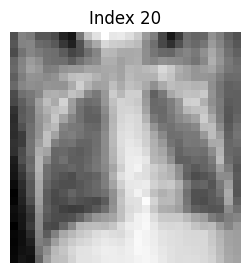

Ground Truth   : 0
CNN Prediction : 1
CNN Status     : ❌ Misclassified

VLM Report:

USER:  
You are an expert thoracic radiologist.
Analyze the chest X-ray focusing on:
- Lung opacity
- Consolidation
- Infiltrates
Provide a concise clinical report.ASSISTANT: The chest X-ray shows a large, irregularly shaped mass in the left upper lobe of the lung. The mass appears to be infiltrating the surrounding lung tissue, and there is a significant amount of consolidation present. The presence of these findings suggests a possible diagnosis of lung cancer or a similar condition. It is important to consult with a medical professional for further evaluation and treatment options.

----------------------------------------------------------------------



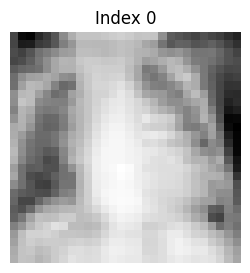

Ground Truth   : 1
CNN Prediction : 1
CNN Status     : ✅ Correct

VLM Report:

USER:  
You are an expert thoracic radiologist.
Analyze the chest X-ray focusing on:
- Lung opacity
- Consolidation
- Infiltrates
Provide a concise clinical report.ASSISTANT: The chest X-ray shows a large, dark mass in the upper right lobe of the lung. The mass appears to be infiltrating the surrounding lung tissue, indicating a potential malignancy. There is also a small, round, white spot in the lower left lobe of the lung, which could be a benign lesion or a metastatic nodule. The presence of these abnormalities suggests that the patient may have lung cancer or another form of lung disease. A more detailed evaluation, such as a CT scan or a biopsy, would be necessary to confirm the diagnosis and determine the appropriate course of treatment.

----------------------------------------------------------------------



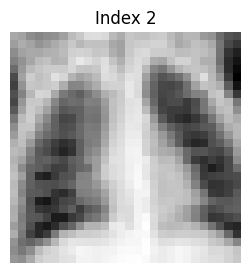

Ground Truth   : 1
CNN Prediction : 1
CNN Status     : ✅ Correct

VLM Report:

USER:  
You are an expert thoracic radiologist.
Analyze the chest X-ray focusing on:
- Lung opacity
- Consolidation
- Infiltrates
Provide a concise clinical report.ASSISTANT: The chest X-ray shows a right upper lobe consolidation, which is a type of lung opacity. The consolidation is located in the right upper lobe, and it appears to be a solid mass. The presence of this consolidation suggests that there might be an infection or inflammation in the affected area. It is essential to consult a medical professional for further evaluation and treatment.

----------------------------------------------------------------------



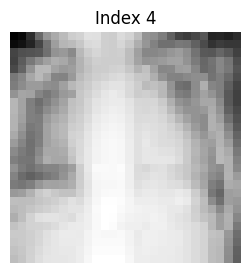

Ground Truth   : 1
CNN Prediction : 1
CNN Status     : ✅ Correct

VLM Report:

USER:  
You are an expert thoracic radiologist.
Analyze the chest X-ray focusing on:
- Lung opacity
- Consolidation
- Infiltrates
Provide a concise clinical report.ASSISTANT: The chest X-ray shows a large, diffuse, and dense infiltrate in the right lung, which is likely to be a malignant process. The left lung appears to be clear. The presence of a large infiltrate suggests that the patient may have a lung cancer, and further investigation, such as a biopsy, is recommended to confirm the diagnosis. The patient should be referred to a specialist for further management and treatment.

----------------------------------------------------------------------



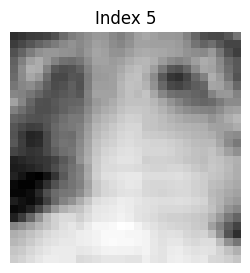

Ground Truth   : 1
CNN Prediction : 1
CNN Status     : ✅ Correct

VLM Report:

USER:  
You are an expert thoracic radiologist.
Analyze the chest X-ray focusing on:
- Lung opacity
- Consolidation
- Infiltrates
Provide a concise clinical report.ASSISTANT: The chest X-ray shows a right-sided lung infiltrate, which is a type of lung opacity. The infiltrate appears to be consolidated, indicating that the affected area is filled with fluid or pus, rather than air. This could suggest an infection or inflammation in the lung. The presence of this infiltrate warrants further investigation and possibly a referral to a pulmonologist for a more detailed evaluation and management plan.

----------------------------------------------------------------------



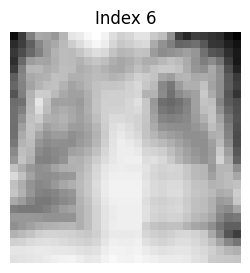

Ground Truth   : 1
CNN Prediction : 1
CNN Status     : ✅ Correct

VLM Report:

USER:  
You are an expert thoracic radiologist.
Analyze the chest X-ray focusing on:
- Lung opacity
- Consolidation
- Infiltrates
Provide a concise clinical report.ASSISTANT: The chest X-ray shows a person with a large, dark mass in the upper left quadrant of the chest. The mass appears to be infiltrating the lung, and there is a significant amount of consolidation in the area. The presence of this mass suggests a potential diagnosis of lung cancer or another malignant condition. The patient should be referred to a specialist for further evaluation and treatment.

----------------------------------------------------------------------



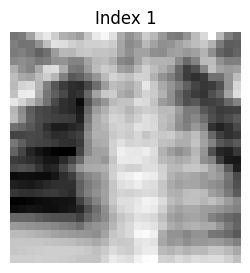

Ground Truth   : 0
CNN Prediction : 1
CNN Status     : ❌ Misclassified

VLM Report:

USER:  
You are an expert thoracic radiologist.
Analyze the chest X-ray focusing on:
- Lung opacity
- Consolidation
- Infiltrates
Provide a concise clinical report.ASSISTANT: The chest X-ray shows a large, irregularly shaped mass in the right upper lobe of the lung. The mass appears to be infiltrating the surrounding lung tissue, causing a significant amount of consolidation. The presence of this mass suggests the possibility of a malignant tumor, such as a lung cancer. The patient should be referred to a specialist for further evaluation and management.

----------------------------------------------------------------------



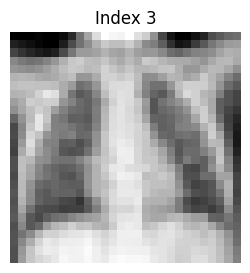

Ground Truth   : 0
CNN Prediction : 1
CNN Status     : ❌ Misclassified

VLM Report:

USER:  
You are an expert thoracic radiologist.
Analyze the chest X-ray focusing on:
- Lung opacity
- Consolidation
- Infiltrates
Provide a concise clinical report.ASSISTANT: The image displays a chest X-ray of a person, focusing on the lungs and the surrounding area. There is a noticeable opacity in the left lower lobe of the lung, which could indicate a consolidation or infiltrate. The presence of this opacity suggests that the patient might be experiencing respiratory issues or an infection in the affected area. It is essential to consult a medical professional for further evaluation and treatment.

----------------------------------------------------------------------



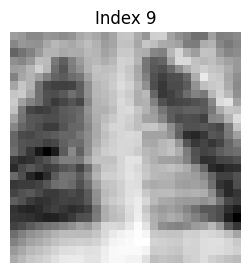

Ground Truth   : 0
CNN Prediction : 1
CNN Status     : ❌ Misclassified

VLM Report:

USER:  
You are an expert thoracic radiologist.
Analyze the chest X-ray focusing on:
- Lung opacity
- Consolidation
- Infiltrates
Provide a concise clinical report.ASSISTANT: The chest X-ray shows a right-sided lung infiltrate, which is a type of lung opacity. The infiltrate is located in the lower lobe of the right lung, and it appears to be a consolidation, which is a type of lung consolidation. The presence of this infiltrate suggests that the patient may have an underlying respiratory condition, such as chronic obstructive pulmonary disease (COPD) or lung cancer. It is important for the patient to seek medical attention to determine the cause of the infiltrate and to receive appropriate treatment.

----------------------------------------------------------------------

Final CNN Accuracy on Selected Set: 0.38461538461538464


In [12]:
print("="*70)
print("Integrated CNN + VLM Evaluation")
print("="*70)

# Select:
# 5 normal
# 5 pneumonia
# + misclassified

selected_indices = []

# 5 Normal
count = 0
for i in range(len(dataset)):
    _, label = dataset[i]
    if label.item() == 0:
        selected_indices.append(i)
        count += 1
    if count == 5:
        break

# 5 Pneumonia
count = 0
for i in range(len(dataset)):
    _, label = dataset[i]
    if label.item() == 1:
        selected_indices.append(i)
        count += 1
    if count == 5:
        break

# Add misclassified
selected_indices += misclassified

correct = 0

for idx in selected_indices:

    img, label = dataset[idx]
    input_tensor = img.unsqueeze(0).to(device)

    with torch.no_grad():
        output = cnn_model(input_tensor)
        pred = torch.argmax(output, dim=1).item()

    img_pil = transforms.ToPILImage()(img)
    report = generate_report(img_pil, PROMPTS["structured"])

    plt.figure(figsize=(3,3))
    plt.imshow(img.squeeze(), cmap="gray")
    plt.axis("off")
    plt.title(f"Index {idx}")
    plt.show()

    print("Ground Truth   :", label.item())
    print("CNN Prediction :", pred)

    if pred == label.item():
        print("CNN Status     : ✅ Correct")
        correct += 1
    else:
        print("CNN Status     : ❌ Misclassified")

    print("\nVLM Report:\n")
    print(report)

    print("\n" + "-"*70 + "\n")

print("Final CNN Accuracy on Selected Set:", correct/len(selected_indices))


In [13]:
print("="*70)
print("CNN–VLM Alignment Analysis")
print("="*70)

pneumonia_keywords = ["opacity", "consolidation", "infiltrate", "infection"]
normal_keywords = ["clear", "normal", "no abnormality", "unremarkable"]

vlm_agrees_with_label = 0
vlm_total = 0

for idx in selected_indices:

    img, label = dataset[idx]
    img_pil = transforms.ToPILImage()(img)

    report = generate_report(img_pil, PROMPTS["structured"])
    report_lower = report.lower()

    vlm_total += 1

    if label.item() == 1:
        if any(word in report_lower for word in pneumonia_keywords):
            vlm_agrees_with_label += 1
    else:
        if any(word in report_lower for word in normal_keywords):
            vlm_agrees_with_label += 1

print(f"VLM Alignment with Ground Truth: {vlm_agrees_with_label}/{vlm_total}")
print(f"Alignment Score: {vlm_agrees_with_label / vlm_total:.4f}")


CNN–VLM Alignment Analysis
VLM Alignment with Ground Truth: 5/13
Alignment Score: 0.3846
